# <center>**- TP n°11 : PCA, ICA, NMF -**</center>

## <center>- SÉPARATION DE SOURCES AUDIO PAR ICA -</center>

On se propose dans cette première partie d’utiliser l’ICA pour séparer les deux sources audio (monophoniques) $s_k(n), k ∈ \{1, 2\}$, qui composent un mélange stéréophonique $x_l(n), l ∈ \{1, 2\}$, dit *linéaire instantané*, c’est-à-dire obtenu par combinaisons linéaires des sources monophoniques suivantes :
$$
x_l(n) = \sum_{k=1}^2 a_{l,k}s_k(n) ;
$$
les coefficients $a_{l,k}$ étant les gains de mixage, autrement dit les intensités avec lesquelles les sources contribuent à chaque mélange.

In [2]:
import pandas as pd
import pylab as pl
import numpy as np
import wave
import matplotlib.pyplot as plt

from scipy.io import wavfile as wav
import IPython.display as ipd
from sklearn import decomposition
from sklearn.decomposition import FastICA

In [8]:
# ica_audio.py 1/2

######################## Read audio data ########################
def wavread(filename):
    wf = wave.open(filename)
    s = np.frombuffer(wf.readframes(wf.getnframes()), dtype=np.int16)
    wf.close()
    return s

def wavwrite(filename, s, nchannels=1):
    wf = wave.open(filename,'wb')
    wf.setnchannels(nchannels)
    wf.setsampwidth(2)
    wf.setframerate(32000)
    s = s/max(abs(s))*2**14 # normalise arbitrarily
    wf.writeframes(s.astype(np.int16).tostring())
    wf.close()
    
s1 = wavread('./snd/es02.wav')
s2 = wavread('./snd/si01.wav')

In [6]:
# ica_audio.py 2/2

######################## Create stereo mix ########################
nsmp = min(len(s1), len(s2))
s1 = s1[:nsmp]
s2 = s2[:nsmp]
S = np.c_[s1, s2]

# Mixing matrix
A = np.array([ [0.6, 0.5],
              [0.4, 0.5]
             ])

# Do the mix
X = S.dot(A)

# Write mix file
x = np.zeros(2*nsmp)
x[::2] = X[:,0]
x[1::2] = X[:,1]
wavwrite('./snd/mix.wav', x, nchannels=2) #nchannels=2 car nous avons mixé 2 sources ici

### Question 1 :
Étudier le script `ica_audio.py` et l’utiliser pour générer le mélange stéréo. Prendre le temps d’écouter les différents signaux.

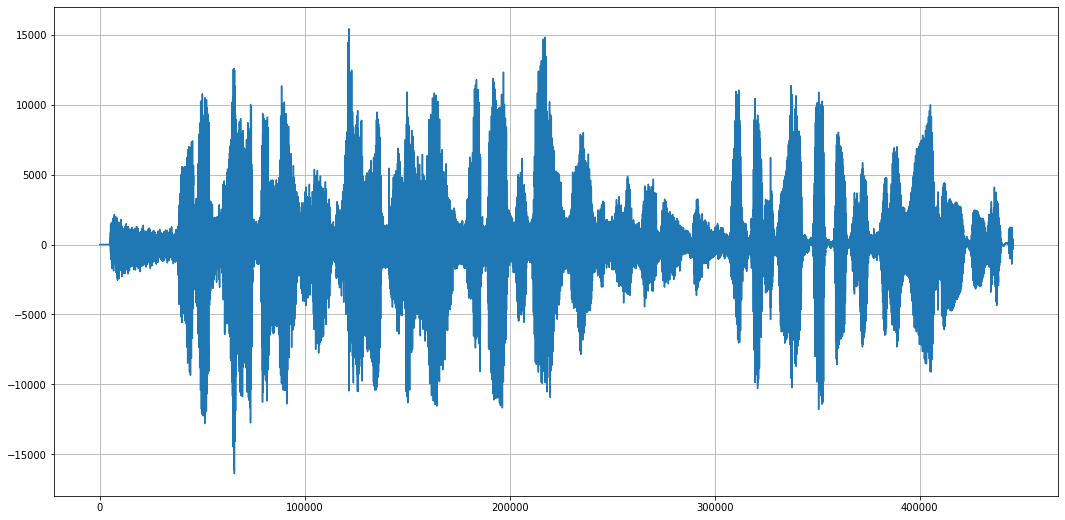

In [17]:
mix = wavread('./snd/mix.wav')
plt.figure(figsize=(18,9))
plt.plot(mix)
plt.grid(True) 
plt.show()

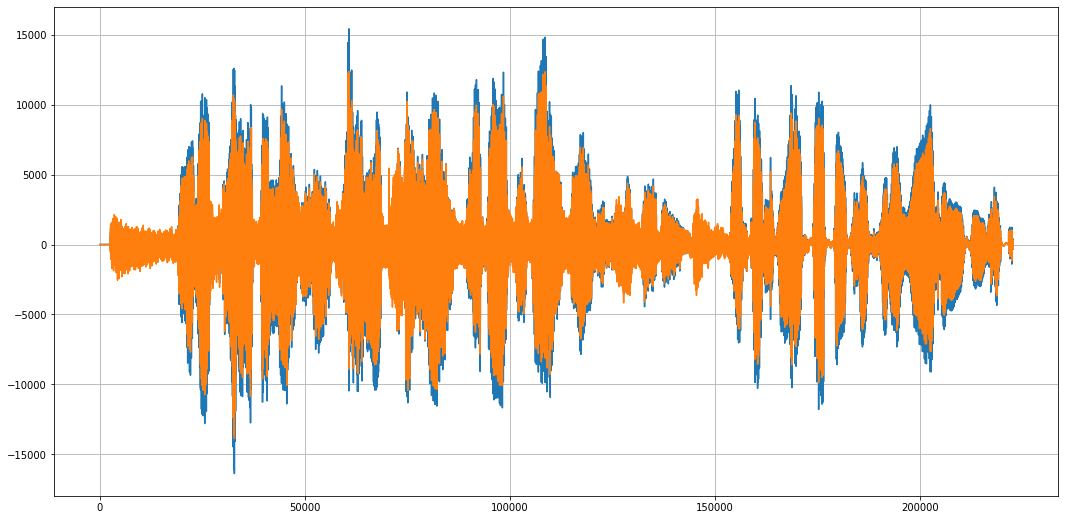

In [16]:
rate, data = wav.read('./snd/mix.wav')
plt.figure(figsize=(18,9))
plt.plot(data)
plt.grid(True) 
plt.show()

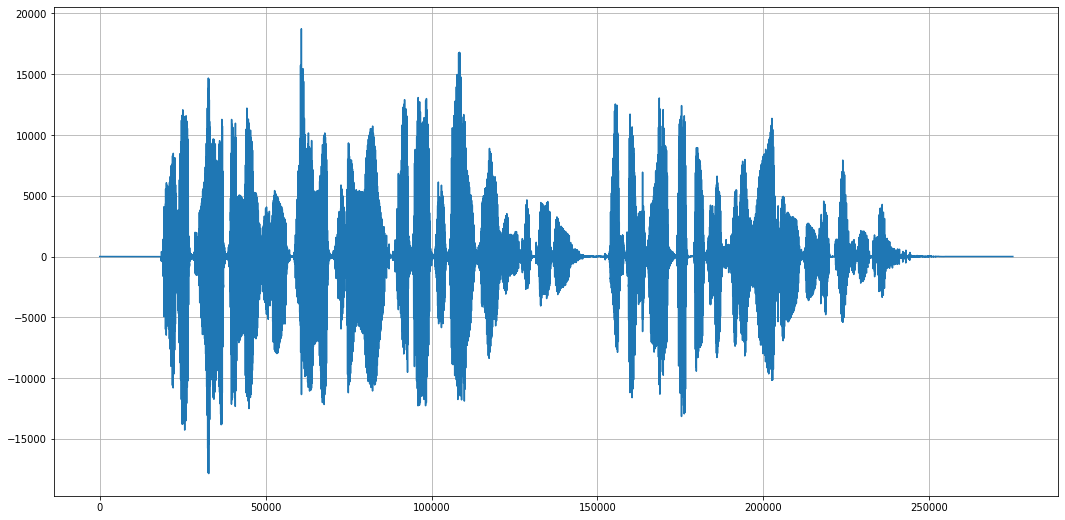

In [12]:
plt.figure(figsize=(18,9))
plt.plot(s1)
plt.grid(True) 
plt.show()

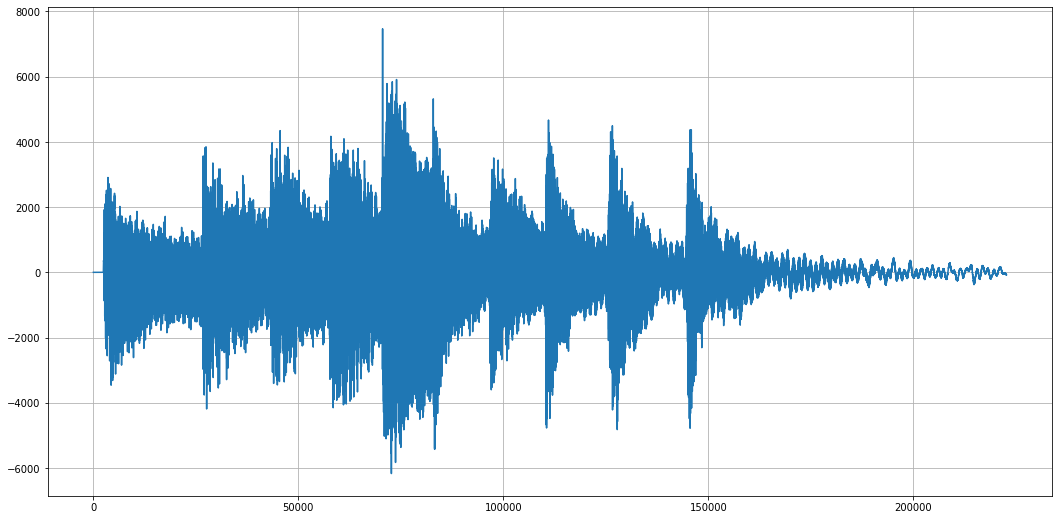

In [13]:
plt.figure(figsize=(18,9))
plt.plot(s2)
plt.grid(True) 
plt.show()

In [19]:
ipd.Audio('./snd/mix.wav')

In [20]:
ipd.Audio('./snd/es02.wav')

In [21]:
ipd.Audio('./snd/si01.wav')

### Question 2 :
Utiliser l’ICA pour extraire les sources originales à partir du mélange. On exploitera pour cela `sklearn.decomposition.FastICA`.

In [31]:
transformer = FastICA(n_components=2,random_state=0)
X_transformed = transformer.fit_transform(data)
X_s1 = X_transformed[:,0]
X_s2 = X_transformed[:,1]

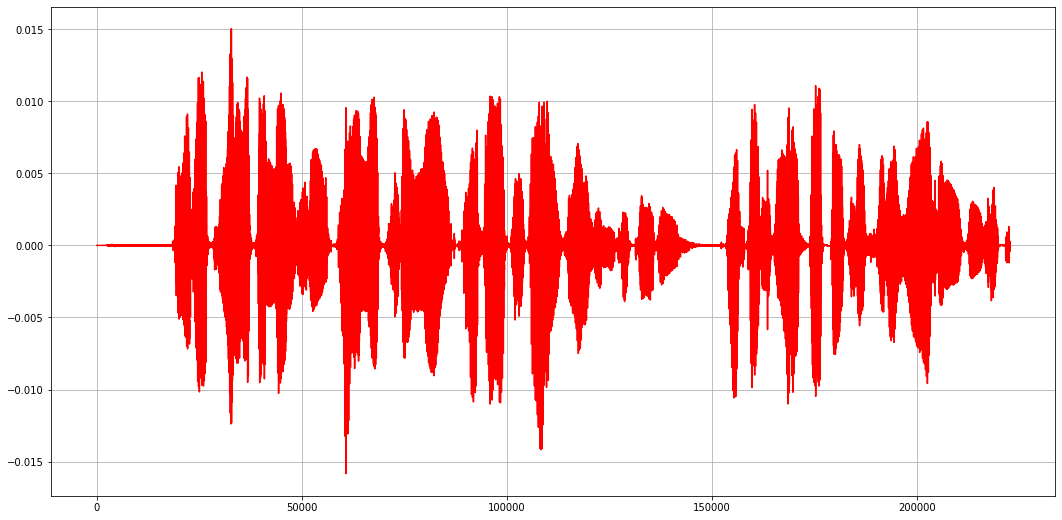

In [61]:
plt.figure(figsize=(18,9))
plt.plot(X_s1, c='red')
plt.grid(True) 
plt.show()

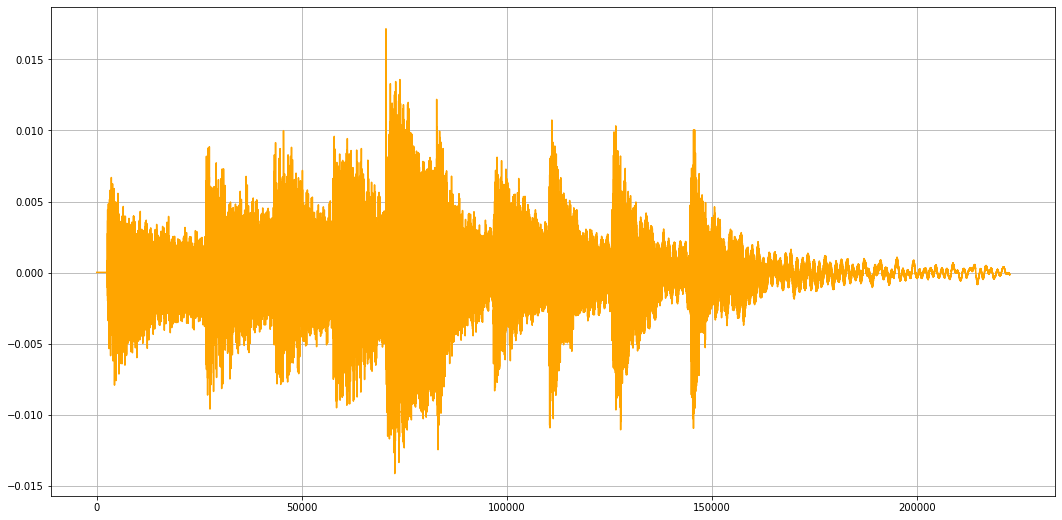

In [26]:
plt.figure(figsize=(18,9))
plt.plot(X_s2, c='orange')
plt.grid(True) 
plt.show()

### Question 3 :
Créer les fichiers audio pour chaque source extraite et les écouter.

In [48]:
wavwrite('./snd/mix_1.wav', X_s1, nchannels=1)  # nchannels=1 car nous avons 1 seule source ici
wavwrite('./snd/mix_2.wav', X_s2, nchannels=1)

In [49]:
ipd.Audio('snd/mix_1.wav')

In [50]:
ipd.Audio('snd/mix_2.wav')

## <center>- EXTRACTION DE CARACTÉRISTIQUES DE VISAGES -</center>

On étudie ici l’utilisation des techniques de décomposition par PCA et NMF pour l’extraction de caractéristiques utiles à la reconnaissance automatique de visages.

In [51]:
# pca_nmf_faces.py
# Authors: Vlad Niculae, Alexandre Gramfort, Slim Essid
# License: BSD
from time import time
from numpy.random import RandomState

import pylab as pl
import numpy as np
from sklearn.datasets import fetch_olivetti_faces
from sklearn import decomposition

### Question 1 : 
Étudier et tester le script `pca_nmf_faces.py`. Analyser le type de décomposition obtenu par NMF en comparaison avec celui obtenu par PCA.

Dataset consists of 400 faces
2061 negative-valued pixels
2773 negative-valued pixels
2630 negative-valued pixels
1422 negative-valued pixels
1242 negative-valued pixels
1004 negative-valued pixels
2049 negative-valued pixels
1580 negative-valued pixels
1387 negative-valued pixels
3819 negative-valued pixels


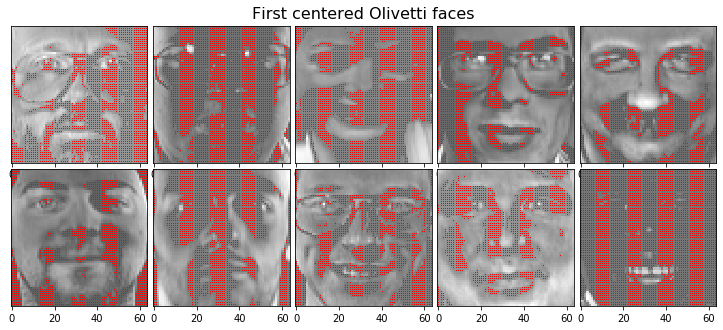

In [53]:
# -- Prepare data and define utility functions ---------------------------------

n_row, n_col = 2, 5
n_components = n_row * n_col
image_shape = (64, 64)
rng = RandomState(0)

# Load faces data
dataset = fetch_olivetti_faces(shuffle=True, random_state=rng)
faces = dataset.data
n_samples, n_features = faces.shape

# global centering
faces_centered = faces - faces.mean(axis=0, dtype=np.float64)
print ("Dataset consists of %d faces" % n_samples)


def plot_gallery(title, images):
    pl.figure(figsize=(2. * n_col, 2.26 * n_row))
    pl.suptitle(title, size=16)
    for i, comp in enumerate(images):
        pl.subplot(n_row, n_col, i + 1)
        comp = comp.reshape(image_shape)
        vmax = comp.max()
        vmin = comp.min()
        dmy = np.nonzero(comp<0)
        if len(dmy[0])>0:
            yz, xz = dmy
        comp[comp<0] = 0

        pl.imshow(comp, cmap=pl.cm.gray, vmax=vmax, vmin=vmin)
        #print ("vmax: %f, vmin: %f" % (vmax, vmin))
        #print (comp)
        
        if len(dmy[0])>0:
            pl.plot( xz, yz, 'r,')
            print (len(dmy[0]), "negative-valued pixels")

        pl.yticks(())
        pl.subplots_adjust(0.01, 0.05, 0.99, 0.93, 0.04, 0.)

# Plot a sample of the input data
plot_gallery("First centered Olivetti faces", faces_centered[:n_components])


Extracting the top 10 Eigenfaces - PCA...
done in 0.226s
3998 negative-valued pixels
2078 negative-valued pixels
1967 negative-valued pixels
1862 negative-valued pixels
2261 negative-valued pixels
1924 negative-valued pixels
1951 negative-valued pixels
1883 negative-valued pixels
2222 negative-valued pixels
2128 negative-valued pixels
Extracting the top 10 Non-negative components - NMF...
done in 19.219s


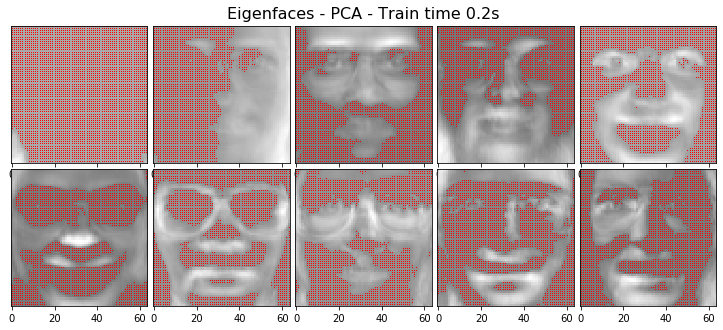

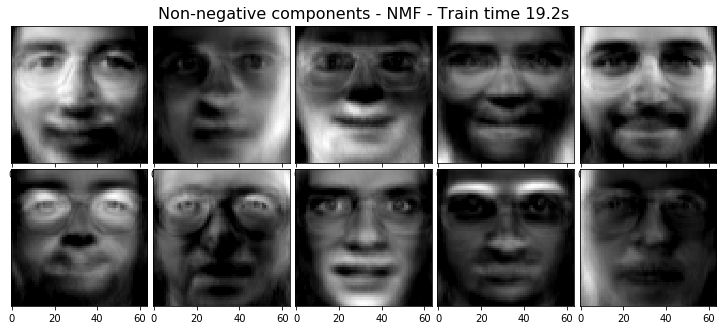

In [63]:
# -- Decomposition methods -----------------------------------------------------

# List of the different estimators and whether to center the data
estimators = [
    ('pca', 'Eigenfaces - PCA',
    decomposition.PCA(n_components=n_components, whiten=True),
    True),
    
    ('nmf', 'Non-negative components - NMF',
    decomposition.NMF(n_components=n_components, init=None, tol=1e-6,
    max_iter=2000),
    False)
]


# -- Transform and classify ----------------------------------------------------
labels = dataset.target
X = faces
X_ = faces_centered

for shortname, name, estimator, center in estimators:
    #if shortname != 'nmf': continue
    print ("Extracting the top %d %s..." % (n_components, name))
    t0 = time()
    
    data = X
    if center:
        data = X_
    
    data = estimator.fit_transform(data)
    
    train_time = (time() - t0)
    print ("done in %0.3fs" % train_time)

    components_ = estimator.components_

    plot_gallery('%s - Train time %.1fs' % (name, train_time), 
                 components_[:n_components])

### Question 2 :
Modifier le script pour réaliser une évaluation des performances d’un système de reconnaissance automatique de visages utilisant les caractéristiques extraites par PCA, comparées à celles obtenues par un système exploitant les caractéristiques extraites par NMF. On pourra utiliser la LDA pour la classification. On effectuera l’évaluation par validation croisée. On observera l’évolution des scores en faisant varier le nombre de composantes utilisé dans les décompositions.

In [64]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import cross_val_score

In [67]:
accuracy_pca = []
accuracy_nmf = []

for n_components in [6, 10, 14, 18, 25, 50] :
    print('\n      n_components = {}'.format(n_components))
    estimators = [
        ('pca', 'Eigenfaces - PCA',
         decomposition.PCA(n_components=n_components, whiten=True),True),

        ('nmf', 'Non-negative components - NMF',
         decomposition.NMF(n_components=n_components, init=None, tol=1e-6,max_iter=1000),False)
    ]

    labels = dataset.target
    X = faces
    X_ = faces_centered

    for shortname, name, estimator, center in estimators:

        #print("Extracting the top %d %s..." % (n_components, name))
        t0 = time()

        data = X
        if center:
            data = X_
        
        ### Fit Transform Data  
        data = estimator.fit_transform(data)
    
        ### Fit the LDA
        clf = LinearDiscriminantAnalysis()
        y_pred = cross_val_score(clf, data, labels, cv=5)
        
        if shortname == 'pca' :
            accuracy_pca.append(y_pred.mean())
        else :
            accuracy_nmf.append(y_pred.mean())
        print("Accuracy Score " + str(name) + ": " + str(round(y_pred.mean(),2)))
    
        train_time = (time() - t0)
        print("done in %0.3fs" % train_time)
    
        components_ = estimator.components_

        #plot_gallery('%s - Train time %.1fs' % (name, train_time),omponents_[:n_components])
        #plt.show()


 n_components = 6
Accuracy Score Eigenfaces - PCA: 0.69
done in 0.355s
Accuracy Score Non-negative components - NMF: 0.69
done in 8.300s

 n_components = 10
Accuracy Score Eigenfaces - PCA: 0.84
done in 0.181s
Accuracy Score Non-negative components - NMF: 0.88
done in 10.203s

 n_components = 14
Accuracy Score Eigenfaces - PCA: 0.91
done in 0.201s
Accuracy Score Non-negative components - NMF: 0.91
done in 13.809s

 n_components = 18
Accuracy Score Eigenfaces - PCA: 0.94
done in 0.245s
Accuracy Score Non-negative components - NMF: 0.94
done in 16.593s

 n_components = 25
Accuracy Score Eigenfaces - PCA: 0.96
done in 0.344s
Accuracy Score Non-negative components - NMF: 0.97
done in 34.019s

 n_components = 50
Accuracy Score Eigenfaces - PCA: 0.97
done in 0.396s
Accuracy Score Non-negative components - NMF: 0.98
done in 64.671s


> La **NMF semble donc légèrement meilleure que la PCA** dans ce cas et pour les différentes valeurs de composantes choisies. Elle est en revanche **beaucoup plus longue à tourner** donc pour le gain de score obtenu, **il vaut mieux choisir une PCA**.

> On remarque également que plus on augmente le nombre de composantes à analyser dans le visage, plus l'accuracy est bonne. Ce paramètre n'influence d'ailleurs que très peu le temps de calcul pour la PCA contrairement à la NMF. **Ceci nous conforte une fois encore dans le choix d'une PCA.**

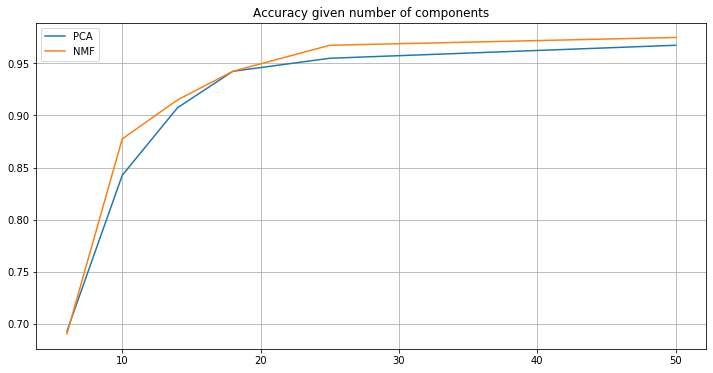

In [68]:
plt.figure(figsize=(12,6))
plt.plot([6, 10, 14, 18, 25, 50], accuracy_pca, label="PCA")
plt.plot([6, 10, 14, 18, 25, 50], accuracy_nmf, label="NMF")
plt.title("Accuracy given number of components")
plt.legend()
plt.grid(True)
plt.show()

## <center>- EXTRACTION DE THÈMES À PARTIR DE TEXTES -</center>

Il s’agit dans cette partie de tester l’utilisation de la NMF pour l’extraction de thèmes à partir
d’un corpus de textes ; l’idée principale étant d’interpréter chaque composante NMF extraite
comme étant associée à un thème. Étudier et tester le script suivant (introduit sur https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html). Si possible appliquer la même technique aux données de votre projet.

In [69]:
# Author: Olivier Grisel <olivier.grisel@ensta.org>
# License: Simplified BSD
from time import time
from sklearn.feature_extraction import text
from sklearn import decomposition
from sklearn import datasets

In [75]:
n_samples = 1000
n_features = 1000
n_topics = 10
n_top_words = 20

# Load the 20 newsgroups dataset and vectorize it using the most common word
# frequency with TF-IDF weighting (without top 5% stop words)

t0 = time()
print("Loading dataset and extracting TF-IDF features...")
dataset = datasets.fetch_20newsgroups(shuffle=True, random_state=1)

vectorizer = text.CountVectorizer(max_df=0.95, max_features=n_features, stop_words='english')
counts = vectorizer.fit_transform(dataset.data[:n_samples])
tfidf = text.TfidfTransformer().fit_transform(counts)
print("done in %0.3fs." % (time() - t0))

# Fit the NMF model
print("Fitting the NMF model on with n_samples=%d and n_features=%d..." % (
    n_samples, n_features))
nmf = decomposition.NMF(n_components=n_topics).fit(tfidf)
print("done in %0.3fs." % (time() - t0))

# Inverse the vectorizer vocabulary to be able
feature_names = vectorizer.get_feature_names()

for topic_idx, topic in enumerate(nmf.components_):
    print("Topic #%d:" % topic_idx)
    print(" ".join([feature_names[i]
                    for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print("")

Loading dataset and extracting TF-IDF features...
done in 1.035s.
Fitting the NMF model on with n_samples=1000 and n_features=1000...
done in 1.486s.
Topic #0:
god bible jesus christian people life christians christ religion faith mary believe christianity church belief say think children good does

Topic #1:
edu university cs host posting nntp article cc writes reply distribution uiuc state washington john cwru pitt david michael baseball

Topic #2:
com hp article writes netcom sun corp stratus posting nntp host portal jim news distribution att reply uunet support systems

Topic #3:
windows drive help card problem software monitor file dos using drivers use driver pc color thanks window computer version video

Topic #4:
clipper key chip encryption government keys public secure use enforcement people law house secret brad algorithm standard phone pat security

Topic #5:
nasa gov space jpl center research shuttle moon program distribution laboratory brian earth world data sci posting nn

> Il est important d'enlever les ***stops words*** dans la fonction `CountVectorizer` pour ne pas prendre en compte tous les petits mots de liason qui n'ont pas de sens en eux-même et ne permettent pas de déduire le sujet d'un texte.